# ResNet in `gluon`

In this notebook we are going to:

1. Implement the popular ResNet18 convolutional neural network in just a few lines of code.
2. Use a pretrained model to make predictions on a new image.

ResNet is a powerful model that achieves high accuracy on a number computer vision tasks. The main innovation in the development of ResNets was the introduction of *residual connections*. In short, the residual connections change the mappings applied by neural network layers from $h_l = f(h_{1-1})$ (where $f$ is some linear mapping followed by an activation function to $h_l = f(h_{1-1}) + h_{l-1}$. Intuitively, while the easiest function for a normal neural network to learn is to map every vector to the zero vector (by setting all weights to $0$), the easiest mapping for a residual network to learn is the identity function. Another way to think about the benefit of residual networks is that they help with the vanishing gradient problem because the skip connections create shorter paths from the loss to the parameters. 


## ResNet Architecture

<img src="resnet34-landscape.png">



The ResNet we're going to work with in this tutorial consists of several parts.
- Conv layer with 7x7 kernel
- Max pooling
- Stage 1
- Stage 2
- Stage 3
- Stage 4
- Global average pooling
- Fully-connected output layer

Where each stage is a block following the architecture described below.

###### Each stage is built with repeated basic building blocks with residual connection.

<img src="resnet-basicblock.png" width=512>

A basic block has the following components:

- Conv
- Conv
- Add result with input
- RELU Activation

Note that starting from stage 2, we need to double the number of channels and downsample the feature map in the first block. Therefore, the first convolutional layer in the main body needs strides, and the residual path also needs a convolutional layer with strides to downsample the feature map.

This pattern is easy to implement in Gluon.

## Gluon ResNet Implementation 

First, let's implement the basic building block in ResNet.

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from mxnet import nd, image
from mxnet.gluon import nn
from mxnet.gluon.block import HybridBlock
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.model_zoo.vision import get_model

Populating the interactive namespace from numpy and matplotlib


In [2]:
class BasicBlock(HybridBlock):
    def __init__(self, channels, strides, downsample=False, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.body = nn.HybridSequential()
        self.body.add(nn.Conv2D(channels, kernel_size=3, strides=strides, padding=1, use_bias=False),
                      nn.BatchNorm(),
                      nn.Activation('relu'),
                      nn.Conv2D(channels, kernel_size=3, strides=1, padding=1, use_bias=False),
                      nn.BatchNorm())
        self.relu = nn.Activation('relu')
        self.downsample = None
        if downsample:
            self.downsample = nn.HybridSequential()
            self.downsample.add(nn.Conv2D(channels, kernel_size=1, strides=strides, padding=1, use_bias=False),
                                nn.BatchNorm())
    def hybrid_forward(self, F, x):
        residual = x
        x = self.body(x)
        if self.downsample:
            residual = self.downsample(residual)
        return self.relu(residual+x)

Next - the function to construct one stage.

In [3]:
def make_stage(num_blocks, channels, strides, downsample):
    stage = nn.HybridSequential()
    stage.add(BasicBlock(channels=channels, strides=strides, downsample=downsample))
    for i in range(num_blocks-1):
        stage.add(BasicBlock(channels=channels, strides=1, downsample=False))
    return stage

Finally, we can define a ResNet18 structure in gluon easily:

In [4]:
def resnet18(classes):
    net = nn.HybridSequential()
    net.add(nn.Conv2D(channels=64, kernel_size=7, strides=2,
                      padding=3, use_bias=False),
            nn.BatchNorm(),
            nn.Activation('relu'),
            nn.MaxPool2D(pool_size=3, strides=2, padding=1),
            # Stages
            make_stage(2, 64, 1, False),
            make_stage(2, 128, 2, True),
            make_stage(2, 256, 2, True),
            make_stage(2, 512, 2, True),
            # Output
            nn.GlobalAvgPool2D(),
            nn.Dense(classes))
    return net

In [5]:
num_classes = 10
net = resnet18(num_classes)
# print(net)

## Make predictions with a pre-trained ResNet

ImageNet is a large database with over one million natural images. Models trained on this dataset are capable of making accurate predictions on a wide variety of natural images. `Gluon` offers a model zoo with many standard architectures and easily accessible pretrinaed paramameters.

We can demonstrate the power of pretrained models by making prediction on an image.

In [6]:
net = get_model('resnet18_v1', pretrained=True, classes=1000)
img = image.imread('mt_baker.jpg')
plt.figure(figsize=(20, 40))

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

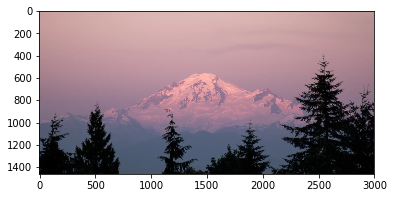

In [7]:
plt.imshow(img.asnumpy())
plt.show()

We need to first process the image with:

- Resize the shorter edge to 256 px, keeping the aspect ratio
- Crop the center 224x224 square
- Transpose the image to tensor format
- Normalize the image with ImageNet parameters

In [8]:
transform_fn = transforms.Compose([
    transforms.Resize(256, keep_ratio=True),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img = transform_fn(img).expand_dims(0)
img.shape

(1, 3, 256, 256)

Now we can simply predict with:

In [9]:
pred = net(img)

Let's see how the result looks like:

In [10]:
with open('imagenet_labels.txt', 'r') as f:
    class_names = [l.strip('\r\n') for l in f.readlines()]
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input picture is classified to be')
for i in range(topK):
    name = class_names[ind[i].asscalar()]
    prob = nd.softmax(pred[0])[ind[i]].asscalar()
    print('\t[%s], with probability %.3f.'% (name, prob))

The input picture is classified to be
	[volcano], with probability 0.788.
	[alp], with probability 0.168.
	[valley], with probability 0.013.
	[lakeside], with probability 0.010.
	[mountain_tent], with probability 0.006.


## Practice

Find a PNG image online. Can the pre-trained model classify it correctly?